# Quorum Sensing: Spatial Aggregation of Evidence

In this approach, evidence of the voting pattern is gathered based on the relative distance between the agents. 

The system consists of $N$ agents which are spatially distributed on a unit square with periodic boundary conditions. Each agent has made a _True/False_ decision about some arbitrary problem. The decision of each agent is _True_ with a given probability.

At each time instance, each agent $i$ does the following:

- __Move:__ Randomly moves a small distance in space.
- __Aggregate:__ Increases its evidence variable $E_i$ for every other agent $j$ in the system that has voted _True_. The amount by which the variable increases depends inversely of the distance $d_{i,j}$ between the two agents.
- __Forget:__ Decreases its evidence variable $E_i$ by a constant fraction $\tau$ of its current value.

Therefore,
$$ E_i(t+1) = E_i(t) + \sum_{j \neq i} \frac{\lambda}{d_{i,j}} - \tau E_i(t) $$

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## The Decision Making Agent

Each `Agent` is characterized by its spatial co-ordinates `x` and `y`, its `decision` regarding the aribtrary problem and the `evidence` that it has gathered. Initially the agents are distributed randomly on the unit square and have `evidence = 0`. Their decision state can be `decision = True` with probability `p`.

As the time evolves, the agents move randomly. The `wrap` function implements the periodic boundary conditions on the system and brings any agents which have the unit square back inside it.

In [16]:
class Agent:

    def __init__(self,p):
        (self.x, self.y) = np.random.random(2)

        self.evidence = 0.0

        if np.random.random() < p:
            self.decision = True
        else:
            self.decision = False

    def wrap(self):
        if self.x > 1:
            self.x -= 1
        elif self.x < 0:
            self.x += 1

        if self.y > 1:
            self.y -= 1
        elif self.y < 0:
            self.y += 1

## Computing Distance Between the Agents

The function `dist_matrix` computes the pairwise Eucledian distance between the agents. _It also takes note of the possibly reduced distance between the nodes due to periodic boundary conditions._

In [17]:
def dist_matrix(S):

    DD = np.zeros((len(S),len(S)))
    for ii in range(len(S)):
        for jj in range(len(S)):
            if abs(S[ii].x - S[jj].x) < 0.5:
                xd = abs(S[ii].x - S[jj].x)
            else:
                xd = 1 - abs (S[ii].x - S[jj].x)
            if abs(S[ii].y - S[jj].y) < 0.5:
                yd = abs(S[ii].y - S[jj].y)
            else:
                yd = 1 - abs (S[ii].y - S[jj].y)
            DD[ii,jj] = np.sqrt(xd**2 + yd**2)
    return DD

## Connecting the Agents

If the agents are to be connected to agents only within a `threshold` distance, the `connect` function may be used. This funcion is not used in the current model.

In [18]:
def connect(S,threshold):

    D = dist_matrix(S)
    C = np.empty((len(D),len(D)), dtype = bool)

    for ii in range(len(D)):
        for jj in range(len(D)):
            if D[ii,jj] < threshold:
                C[ii,jj] = True
            else:
                C[ii,jj] = False

    return C

## Updating Evidence Variable

Given the positions of the agents, the `gather_evidence` function updates the `evidence` variable of the `Agent` according to the equation,

$$ E_i(t+1) = E_i(t) + \sum_{j \neq i} \frac{\lambda}{d_{i,j}} - \tau E_i(t) $$

where $E_i$ is the `evidence` variable of `Agent` $i$.

In [19]:
def gather_evidence(S,N,lam,tau):

    Dist = dist_matrix(S)
    for j in range(N):
        S[j].evidence -= S[j].evidence * tau
        for k in range(N):
            if j != k:
                if S[k].decision == True:
                    S[j].evidence += lam/Dist[j,k]
                    #S[j].evidence += np.exp(-lam * Dist[j,k]**2)

## Moving the Agents

At each time step, the $x_i$ and $y_i$ variables are updated by adding a random number drawn from a normal distribution with $\sigma^2 = dr$. The `move` function updates the `x` and `y` variables of the `Agent` accordingly and also invokes the `wrap` function to accomodate for the periodic boundary conditions.

In [20]:
def move(S,N,dr):

    for j in range(N):

        S[j].x += np.sqrt(dr)*np.sign(np.random.randn())
        S[j].y += np.sqrt(dr)*np.sign(np.random.randn())

        S[j].wrap()

## Setting the System Parameters

In [21]:
def set_parameters(Total_Time=10000, dr=0.0001, N=100, lam=0.1, tau=0.018, prob=1.0):
    
    para = {
        
        'dr': dr,
        'total': Total_Time,
        'N': N,

        'lam': lam,
        'tau': tau,

        'prob': prob,
        
    }
    
    return para

## The Simulation Function

In [22]:
def simulate(para):
    
    pos = np.zeros((para['total'],para['N'],2))

    ZZ = np.zeros(para['total'])

    Z = np.zeros((para['total'],para['N']))

    S = [Agent(para['prob']) for i in range(para['N'])]

    for i in tqdm(range(para['total'])):

        gather_evidence(S,para['N'],para['lam'],para['tau'])

        for j in range(para['N']):

            pos[i,j,0] = S[j].x
            pos[i,j,1] = S[j].y

            Z[i,j] = S[j].evidence

            move(S,para['N'],para['dr'])

    ZZ += np.mean(Z, axis=1)

    norm_factor = 1
    
    out = {
        'positions': pos,
        'evidence_individual': Z,
        'evidence_mean': ZZ
    }
    
    return out

## Set Plotting Axes

In [23]:
def set_plotter_axes(size, xlabel, ylabel):
    plt.figure(figsize=size)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

## Plot Evidence v/s Time Lines

In [24]:
def evidence_plotter(N, output, color, label):
    for i in range(N):
        plt.plot(output['evidence_individual'][:,i],color,alpha=0.03)
    plt.plot(output['evidence_mean'],color,label=label)

## Plot Traces of a Particular Agent

In [25]:
def position_plotter(N, output, index, ti, tf):
    plt.plot(output['positions'][ti:tf,index,0], output['positions'][ti:tf,index,1], '.r')
    plt.show()

## Running the Code

100%|██████████| 10000/10000 [10:09<00:00, 16.40it/s]


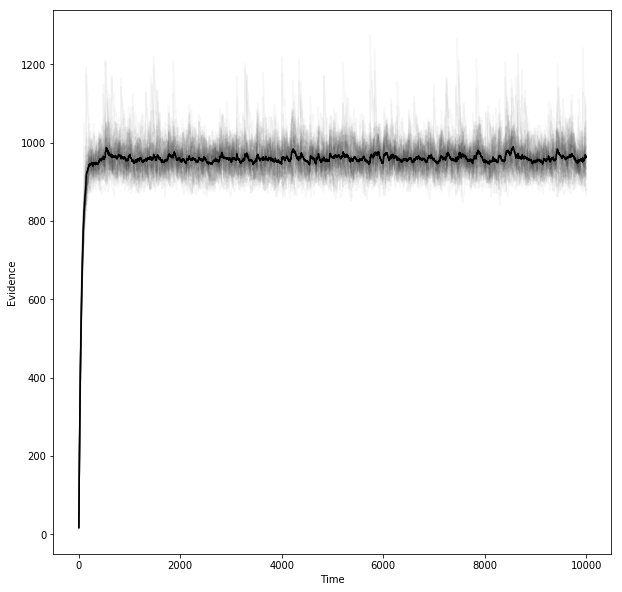

In [28]:
set_plotter_axes((10,10), 'Time', 'Evidence')
para = set_parameters(N=50)
output = simulate(para)
evidence_plotter(para['N'],output,'k','')
plt.show()

100%|██████████| 10000/10000 [34:16<00:00,  4.99it/s]


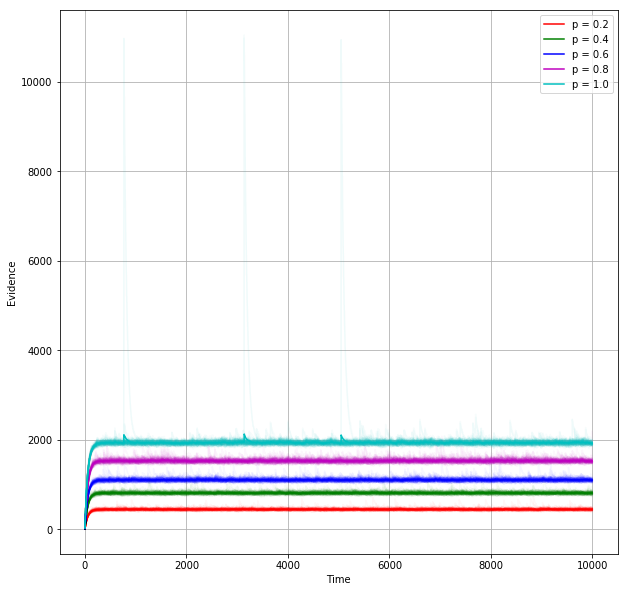

In [29]:
set_plotter_axes((10,10), 'Time', 'Evidence')
pp = [0.2,0.4, 0.6, 0.8, 1.0]
cc = ['r', 'g', 'b', 'm', 'c']
assert len(pp)==len(cc)
for i in range(len(pp)):
    para = set_parameters(N=100,prob=pp[i])
    output = simulate(para)
    ll = 'p = '+str(pp[i])
    evidence_plotter(para['N'],output,cc[i],ll)
plt.legend()
plt.grid()
plt.savefig('Plot.png')
plt.savefig('Plot.pdf')
plt.show()

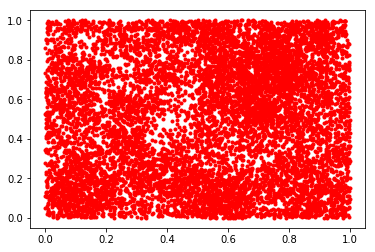

In [14]:
position_plotter(10,output,4,0,10000)